In [18]:
%matplotlib inline
import logging
from eden.util import configure_logging
configure_logging(logging.getLogger(), verbosity=1)

In [19]:
import GArDen.interfaces as garden
from GArDen.convert.sequence import SeqToPathGraph
from GArDen.transform.rna_structure import PathGraphToRNAPlfold

remap={'A0':'A','C0':'C','G0':'G','U0':'E','T0':'E',
       'A1':'V','C1':'S','G1':'Y','U1':'D','T1':'D'}

def remap_with_structure(pos_seqs, remap=remap):
    graphs = garden.transform(pos_seqs, program=SeqToPathGraph())
    graphs = garden.transform(graphs, program=PathGraphToRNAPlfold(max_num_edges=2,
                                                                   window_size=200,
                                                                   max_bp_span=100,
                                                                   hard_threshold=.5,
                                                                   avg_bp_prob_cutoff=.01))
    for graph in graphs:
        paireds = [graph.node[u]['label']+str(int(graph.node[u].get('paired',False))) for u in graph.nodes()]
        paireds = [remap[c] for c in paireds]
        seq = ''.join(paireds)
        yield ('ID',seq)
alphabet = 'protein'
color_scheme = 'chemistry'

In [20]:
def remap_with_structure(pos_seqs):
    for seq in pos_seqs:
        yield seq
alphabet = 'rna'
color_scheme = 'classic'

In [21]:
def filter_pvalue(iterable, pval_threshold=1e-15, less_than=True):
    for header,seq in iterable:
        pval = float(header.split('_')[1])
        if less_than:
            if pval < pval_threshold:
                yield (header,seq)
        else:
            if pval > pval_threshold:
                yield (header,seq)

# SMoD

In [22]:
pos_fname = 'FMR1_predicted_bin_sites.fa'
pos_fname = 'FMR1_bin_sites.fa'
complexity=3
n_clusters=20
min_subarray_size = 5
max_subarray_size = 12

In [23]:
from eden.converter.fasta import fasta_to_sequence
pos_seqs = fasta_to_sequence(pos_fname)
pos_seqs = filter_pvalue(pos_seqs)
from eden.util import iterator_size
num = iterator_size(pos_seqs)
print 'Processing %d sequences' % num
block_size = num / 8

Processing 27147 sequences


Order determined  in 46.53 secs
Cluster 11 (#2326) (42.21 secs)  score: 5 > 0.50


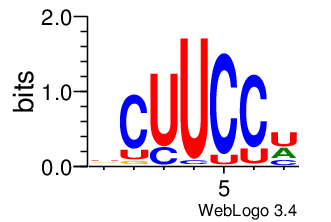

Cluster 16 (#3555) (99.60 secs)  score: 4 > 0.50


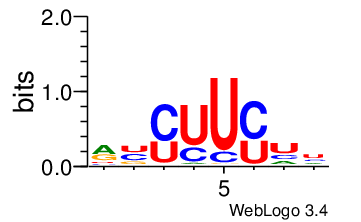

Cluster 12 (#1788) (27.05 secs)  score: 5 > 0.50


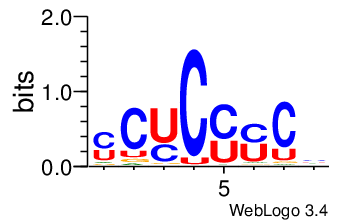

Cluster 14 (#2944) (64.03 secs)  score: 7 > 0.50


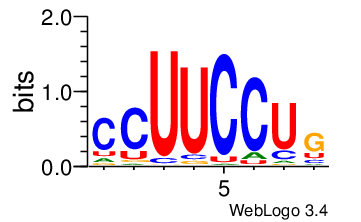

Cluster 15 (#2024) (27.80 secs)  score: 5 > 0.50


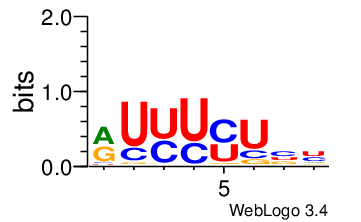

Cluster 3 (#1766) (24.88 secs)  score: 6 > 0.50


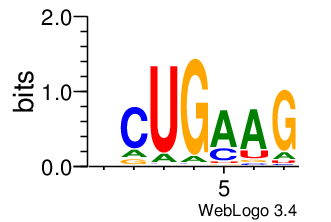

Cluster 7 (#3369) (97.20 secs)  score: 4 > 0.50


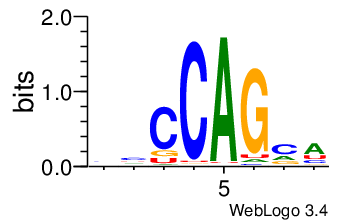

Cluster 8 (#2395) (47.51 secs)  score: 6 > 0.50


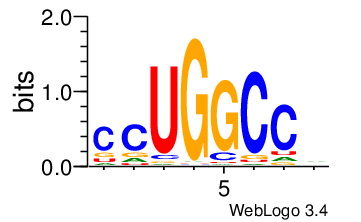

Cluster 13 (#1988) (31.05 secs)  score: 6 > 0.50


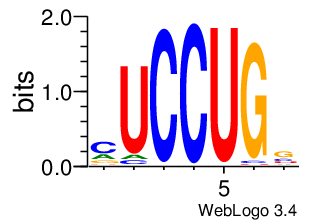

Cluster 9 (#3021) (89.80 secs)  score: 4 > 0.50


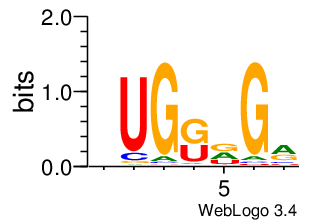

Cluster 18 (#4084) (141.10 secs)  score: 5 > 0.50


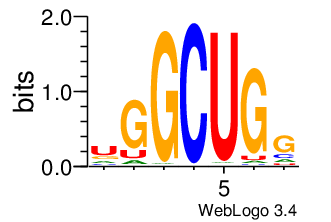

Cluster 4 (#4597) (183.96 secs)  score: 5 > 0.50


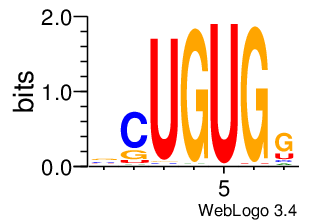

Cluster 0 (#837) (5.16 secs)  score: 5 > 0.50


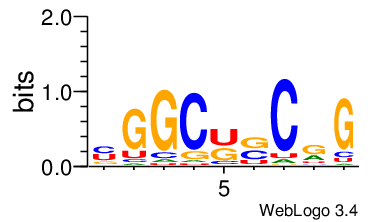

Cluster 1 (#5169) (223.48 secs)  score: 6 > 0.50


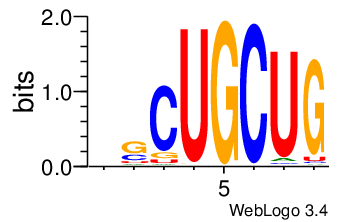

Cluster 6 (#1518) (16.34 secs)  score: 6 > 0.50


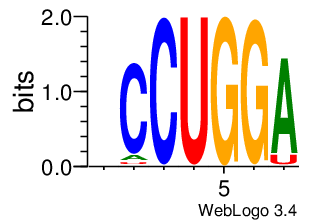

Cluster 17 (#494) (1.94 secs)  score: 7 > 0.50


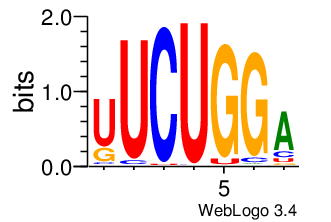

Cluster 5 (#3391) (93.44 secs)  score: 5 > 0.50


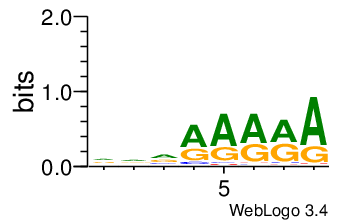

Cluster 10 (#1508) (16.37 secs)  score: 6 > 0.50


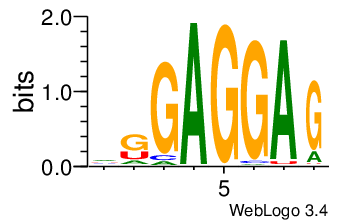

Cluster 2 (#28) (0.17 secs)  score: 9 > 0.50


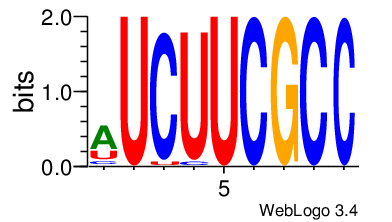

Cluster 19 (#700) (3.79 secs)  score: 8 > 0.50


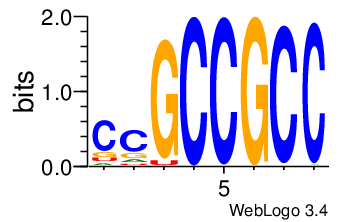

CPU times: user 1min 27s, sys: 10.3 s, total: 1min 37s
Wall time: 30min 49s


In [24]:
%%time
from eden.sequence_motif_decomposer import SequenceMotifDecomposer as SMoD
smod=SMoD(complexity=complexity,
          n_clusters=n_clusters,
          min_subarray_size=min_subarray_size,
          max_subarray_size=max_subarray_size,
          pos_block_size=block_size,
          neg_block_size=block_size)

from eden.converter.fasta import fasta_to_sequence
pos_seqs = fasta_to_sequence(pos_fname)
pos_seqs = filter_pvalue(pos_seqs)
pos_seqs = remap_with_structure(pos_seqs)
#neg_seqs = fasta_to_sequence(neg_fname)
from eden.converter.fasta import fasta_to_sequence
neg_seqs = fasta_to_sequence(pos_fname)
neg_seqs = filter_pvalue(neg_seqs)
neg_seqs = remap_with_structure(neg_seqs)
from eden.modifier.seq import seq_to_seq, shuffle_modifier
neg_seqs = seq_to_seq(neg_seqs, modifier=shuffle_modifier, times=1, order=2)

smod = smod.fit(pos_seqs, neg_seqs)

from eden.converter.fasta import fasta_to_sequence
pos_seqs = fasta_to_sequence(pos_fname)
pos_seqs = filter_pvalue(pos_seqs)
pos_seqs = remap_with_structure(pos_seqs)

clusters = smod.predict(pos_seqs)

logos = smod.display_logos(clusters,
                           output_all=False,
                           min_score=4,
                           min_freq=0.5,
                           min_cluster_size=10)

to do

- join similar clusters
- make a score function for extracting the margin per position
- make a classify function for assigning a class per position
- make a standalone script (to be integrated in galaxy)

---